In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Storm characterisation functions

In [6]:
import gsw
from scipy.interpolate import griddata

def process_storm_data(var, ds_era5, cyclone):

    new_x = np.arange(-1000, 1050, 50)
    new_y = np.arange(-1000, 1050, 50)

    lons = np.ndarray([161])
    lats = np.ndarray([81])
    
    ref_lat = np.round(cyclone.LATITUDE.values, 2)
    ref_lon = np.round(cyclone.LONGITUDE.values, 2)
    
    ds_ = ds_era5.sel(time=cyclone.TIME.values,
                      latitude=slice(np.round(ref_lat) + 10, np.round(ref_lat) - 10),
                      longitude=slice(np.round(ref_lon) - 20.0, np.round(ref_lon) + 20))
     
    lats = ds_.latitude.values
    lons = ds_.longitude.values
    
    # longitude to distance interpolation
    
    dist_from_lon = np.zeros([81, 161])
 
    for j, lt in enumerate(lats):
     
        for i, ln in enumerate(lons):
            dist_from_lon[j, i] = gsw.distance([ln, ref_lon], [lt, lt])[0] / 1000
     
        dist_from_lon[j][lons < ref_lon] = -dist_from_lon[j][lons < ref_lon]
 
    # latitude to distance interpolation
    
    dist_from_lat = np.zeros(lats.size)
 
    for j, lt in enumerate(lats):
        dist_from_lat[j] = gsw.distance([lons[0], lons[0]], [lt, ref_lat])[0] / 1000
 
    dist_from_lat[lats < ref_lat] = -dist_from_lat[lats < ref_lat]
 
    # create xarray dataset 
 
    new_data = np.zeros([81, new_x.size])
 
    final_data = np.zeros([new_x.size, new_y.size])
  
    data = ds_[var]
    for j in range(lats.size):
        new_data[j, :] = griddata(dist_from_lon[j], data[j], new_x)
 
    for i in range(new_x.size):
        final_data[:, i] = griddata(dist_from_lat, new_data[:, i], new_y)
 
    ds_final = xr.Dataset(
        {var: (['time', 'x', 'y'], final_data[np.newaxis, :, :]),
         'pressure': (['time'], [cyclone.PRESSURE_MIN.data]),
         'storm_id': (['time'], [cyclone.STORM_ID.data]),
         },
        coords={
            'x': ('x', new_x),
            'y': ('y', new_y),
            'time': ('time', [pd.to_datetime(cyclone.TIME.data)]),
            'lon': ('time', [ref_lon]),
            'lat': ('time', [ref_lat]),                
        }
    )
    ## Example padding logic (adjust as needed)
    max_time_length = 300  # Define a maximum length for the time dimension
    time_length = ds_final['time'].size  # Get the current length of the time dimension
    #
    if time_length < max_time_length:
        pad_width = max_time_length - time_length
        pad_values = {dim: (0, pad_width) for dim in ds_final.dims if dim == 'time'}
        ds_final = ds_final.pad(pad_values, constant_values=0)           
 
    return ds_final

#### Load glider and ERA5 data

In [2]:
# load the slocum data

sl_grid = xr.open_dataset('/home/mduplessis/data/slocum/slocum_gridded.nc')
sl_xld  = xr.open_dataset('/home/mduplessis/data/slocum/slocum_xld.nc')
sl_eps  = xr.open_dataset('/home/mduplessis/data/slocum/slocum_epsilon.nc')
sl_sst  = xr.open_dataset('/home/mduplessis/data/slocum/slocum_sst_median_10m.nc')

wg = xr.open_dataset('/home/mduplessis/data/waveglider/WG_era5_1h_processed_28Aug2022.nc')

wg['dayofyear'] = (('date'), wg['dayofyear'].data)
wg = wg.sel(date=slice(wg.date[3], wg.date[-1]))

wg = wg.swap_dims({'date': 'dayofyear'})
# wg = wg.drop_vars('date')

In [3]:
# load the ERA5 datasets

ds_era5_vars = xr.open_dataset('/home/mduplessis/data/era5/ds_era5_vars.nc').load()
ds_era5_flux = xr.open_dataset('/home/mduplessis/data/era5/ds_era5_flux.nc').load()

print('merging')

ds_era5_atl = xr.merge([ds_era5_vars, ds_era5_flux])

# process the ERA5 datasets

ds_era5_atl['sp'] = (('time', 'latitude', 'longitude'), ds_era5_atl['sp'].data/100)

ds_era5_atl['wnd'] = (('time', 'latitude', 'longitude'), np.sqrt(ds_era5_atl['u10']**2 + ds_era5_atl['v10']**2).data)

ds_era5_site = ds_era5_atl.sel(longitude=0, latitude=-54)

import matplotlib.dates as mdates

day0=mdates.date2num(np.datetime64('2019-01-01 00:00:00'))

ds_era5_site['dayofyear']=(('time'), mdates.date2num(ds_era5_site.time)-day0)

ds_era5_site = ds_era5_site.sel(time=slice(sl_xld.time.data[0], sl_xld.time.data[-1]))

ds_era5_site['qnet'] = (('time'), ds_era5_site['sshf'].data + ds_era5_site['slhf'].data + ds_era5_site['str'].data + ds_era5_site['ssr'].data)

ds_era5_site['sthf'] = (('time'), ds_era5_site.sshf.data + ds_era5_site.slhf.data)

import functions.dewpoint_to_rh as dp2rh

ds_era5_site = dp2rh.convert_dp_to_rh(ds_era5_site)

ds_era5_site['dt'] = (('time'), ds_era5_site['t2m'].data - ds_era5_site['sst'].data)

merging


In [4]:
# select the ERA5 data for the slocum grid
ds_era5 = ds_era5_atl.sel(time=ds_era5_site.time.values)

In [5]:
# create a dayofyear variable for the ERA5 dataset
ds_era5['dayofyear']=(('time'), mdates.date2num(ds_era5.time)-day0)

In [6]:
# resize the wave glider dataset and find the correlation to the era5 winds

wg = wg.sel(dayofyear=slice(wg.dayofyear[3], wg.dayofyear[-1]))

# CHANGE THE DATES FOR THE WAVE GLIDER AND ERA5 WINDS

u10_era5 = ds_era5_site.sel(time=slice(wg.date[0], wg.date[-1]))

idx = ~np.isnan(wg['WindSpeed_ms_10m'])

print('corr', np.corrcoef(wg['WindSpeed_ms_10m'].data[idx], u10_era5.wnd.data[idx])[0,1]**2)

print('rmse', np.mean(wg['WindSpeed_ms_10m'].data[idx] - u10_era5.wnd.data[idx]))

corr 0.8037282839515881
rmse 1.2267950197915296


#### Process soscex storms

In [22]:
# No need to run this, but if you want to save the dataset. I have run this already, load in the dataset instead below

In [12]:
storm_centers = xr.open_dataset('/home/mduplessis/data/storms/ec_centers_1981_2020.nc')

In [13]:
# cut to only the storms that we need for the project

storm_centers = storm_centers.isel(
    TIME=((storm_centers.TIME >= np.datetime64('2018-12-19 22:00:00')) & 
          (storm_centers.TIME < np.datetime64('2019-03-09 00:00:00')))
    )

idx = ((storm_centers.LONGITUDE.values > -40) & (storm_centers.LONGITUDE.values < 40))

storm_centers = storm_centers.isel(TIME=idx)

idx = ((storm_centers.LATITUDE.values > -70) & (storm_centers.LATITUDE.values < -30))

storm_centers = storm_centers.isel(TIME=idx)

#### Process the storm centers dataset

In [15]:
# process storms -- find if a storm center is within 1000 km of the glider, and if so, process the ERA5 data for that storm

from tqdm import tqdm
import numpy as np
import xarray as xr
import gsw

def process_storms(storm_centers, ds_era5_atl, var='wnd'):

    distance_to_glider = []
    storm_index = []
    ds_final = None
    ds_final_initialized = False

    for i in tqdm(range(storm_centers.STORM_ID.size)):
        ds_storm = storm_centers.isel(TIME=i)
        distance = (gsw.distance([ds_storm.LONGITUDE.values, 0], [ds_storm.LATITUDE.values, -54]) / 1000)[0]

        if distance < 1000:
            distance_to_glider.append(distance)
            storm_index.append(i)

            ds_var = process_storm_data(var, ds_era5_atl, ds_storm)

            if ds_final_initialized:
                ds_final = xr.concat([ds_final, ds_var], dim='time')
            else:
                ds_final = ds_var
                ds_final_initialized = True

    distance_to_glider = np.array(distance_to_glider)
    
    return distance_to_glider, storm_index, ds_final

In [16]:
distance_to_glider, storm_index, ds_storms_shf = process_storms(storm_centers, ds_era5_atl, var='sshf')
distance_to_glider, storm_index, ds_storms_ssr = process_storms(storm_centers, ds_era5_atl, var='ssr')
distance_to_glider, storm_index, ds_storms_lhf = process_storms(storm_centers, ds_era5_atl, var='slhf')
distance_to_glider, storm_index, ds_storms_str = process_storms(storm_centers, ds_era5_atl, var='str')
distance_to_glider, storm_index, ds_storms_wnd = process_storms(storm_centers, ds_era5_atl, var='wnd')


  0%|          | 0/5226 [00:00<?, ?it/s]

100%|██████████| 5226/5226 [12:10<00:00,  7.15it/s] 


In [18]:
ds_storms_ssr = ds_storms_ssr.sel(time=ds_storms_ssr.time<np.datetime64('2019-03-10 00:00:00'))
ds_storms_lhf = ds_storms_lhf.sel(time=ds_storms_lhf.time<np.datetime64('2019-03-10 00:00:00'))
ds_storms_shf = ds_storms_shf.sel(time=ds_storms_shf.time<np.datetime64('2019-03-10 00:00:00'))
ds_storms_str = ds_storms_str.sel(time=ds_storms_str.time<np.datetime64('2019-03-10 00:00:00'))
ds_storms_wnd = ds_storms_wnd.sel(time=ds_storms_wnd.time<np.datetime64('2019-03-10 00:00:00'))


In [20]:
xr.merge([ds_storms_ssr, ds_storms_str, ds_storms_shf, ds_storms_lhf, ds_storms_wnd]).to_netcdf('/home/mduplessis/data/storms/storms_soscex.nc')

#### Load the soscex storm data

In [7]:
storms_soscex = xr.open_dataset('/home/mduplessis/data/storms/storms_soscex.nc')

In [8]:
# Define the threshold distance (radius) in km
threshold_distance = 1000

# Get the dimensions of the array
rows = len(storms_soscex.y)
cols = len(storms_soscex.x)

# Calculate the center point
center_x = rows // 2
center_y = cols // 2

# Create a new 2D array to store the result
radial_idx = np.zeros((rows, cols), dtype=int)*np.nan

# Iterate through the 2D array
for i in range(rows):
    for j in range(cols):
        # Calculate the distance from the center point
        distance = np.sqrt((storms_soscex.x[i] - storms_soscex.x[center_x])**2 + (storms_soscex.y[j] - storms_soscex.y[center_y])**2)
        # Check if the distance is within the threshold
        if distance <= threshold_distance:
            radial_idx[i][j] = 1

In [9]:
storms_soscex['dayofyear']=(('time'), mdates.date2num(storms_soscex.time)-day0)

In [10]:
# process storms -- find if a storm center is within 1000 km of the glider, and if so, save the index 

from tqdm import tqdm
import gsw

# calculate the x and y distance between two coordinates

import math

def calculate_earth_radius(latitude):
    # Equatorial radius (in kilometers)
    a = 6378.137
    # Polar radius (in kilometers)
    b = 6356.752

    # Convert latitude to radians
    lat_rad = math.radians(latitude)

    # Calculate the Earth's radius at the given latitude
    radius = math.sqrt(((a**2 * math.cos(lat_rad))**2 + (b**2 * math.sin(lat_rad))**2) /
                       ((a * math.cos(lat_rad))**2 + (b * math.sin(lat_rad))**2))
    return radius

def calculate_xy_distance(coord1, coord2):
    # Calculate the Earth's radius at the average latitude of the two coordinates
    avg_latitude = (coord1[0] + coord2[0]) / 2
    R = calculate_earth_radius(avg_latitude)

    # Coordinates in radians
    lat1, lon1 = math.radians(coord1[0]), math.radians(coord1[1])
    lat2, lon2 = math.radians(coord2[0]), math.radians(coord2[1])

    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Calculate x (east-west) distance
    x_distance = R * dlon * math.cos((lat1 + lat2) / 2)

    # Calculate y (north-south) distance
    y_distance = R * dlat

    return x_distance, y_distance

# Example coordinates
coord1 = (-33.9249, 18.4241)  # Cape Town
coord2 = (-26.2041, 28.0473)  # Johannesburg

x_distance, y_distance = calculate_xy_distance(coord1, coord2)
print(f"X (east-west) distance: {x_distance} km")
print(f"Y (north-south) distance: {y_distance} km")

def storm_at_glider(ds_storms):

    distance_to_glider = []
    storm_index = []
    x_distance_to_glider = []
    y_distance_to_glider = []

    for i in tqdm(range(ds_storms.time.size)):
        ds_storm = ds_storms.isel(time=i)
        distance = (gsw.distance([ds_storm.lon.values, 0], [ds_storm.lat.values, -54]) / 1000)[0]

        if distance < 1000:
            distance_to_glider.append(distance)
            storm_index.append(i)

            coord1 = (ds_storm.lat.values, ds_storm.lon.values)  # storm step
            coord2 = (-54, 0)  # glider            

            x_distance, y_distance = calculate_xy_distance(coord1, coord2)

            x_distance_to_glider.append(x_distance)
            y_distance_to_glider.append(y_distance)

    distance_to_glider = np.array(distance_to_glider)
    x_distance_to_glider = np.array(x_distance_to_glider)
    y_distance_to_glider = np.array(y_distance_to_glider)
    
    return distance_to_glider, storm_index, x_distance_to_glider, y_distance_to_glider

X (east-west) distance: 926.3506463708823 km
Y (north-south) distance: 858.7568265350349 km


In [11]:
distance_to_glider, storm_index, x_distance_to_glider, y_distance_to_glider = storm_at_glider(storms_soscex)

 46%|████▌     | 398/867 [00:00<00:00, 1323.07it/s]

100%|██████████| 867/867 [00:00<00:00, 1326.37it/s]


(array([  7.,  24.,  44.,  78.,  91.,  92., 119., 116., 120., 176.]),
 array([  8.44076863, 107.49729307, 206.55381751, 305.61034196,
        404.6668664 , 503.72339084, 602.77991528, 701.83643973,
        800.89296417, 899.94948861, 999.00601305]),
 <BarContainer object of 10 artists>)

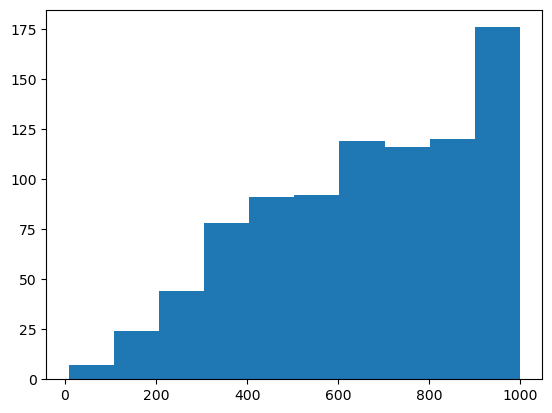

In [12]:
plt.hist(distance_to_glider)

In [13]:
# create a new variable storm_present that indicates if a storm is present at each glider time step

storm_present = []

# Convert times to a common format if necessary
storm_times = set(storms_soscex['time'].values)

for t in ds_era5_site['time'].values:
    if t in storm_times:
        storm_present.append(1)
    else:
        storm_present.append(0)

# Add the storm_present data to your dataset
ds_era5_site['storm_present'] = ('time', storm_present)

/tmp/ipykernel_876613/2620041428.py:101: UserWarning: The following kwargs were not used by contour: 'lw'
  contours = current_ax.contour(


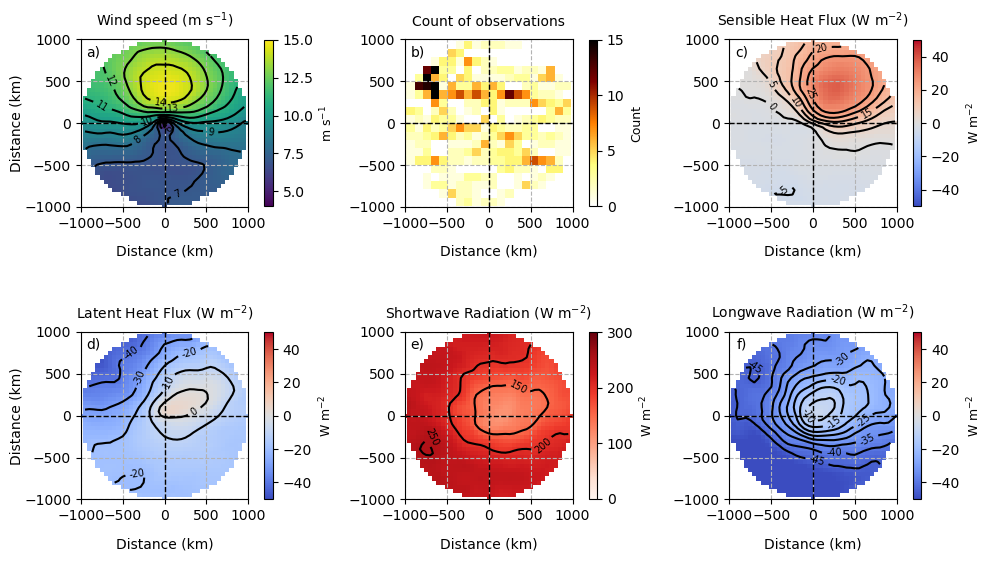

In [42]:
# --- Subplot Setup ---

# Create a figure with 2 rows and 3 columns

fig, ax = plt.subplots(2, 3, figsize=(10, 6)) # Increased figsize for more subplots
ax = ax.flatten() # Flatten the 2D array of axes for easier iteration

# --- Plotting Definitions for each subplot ---
plot_configs = [
    {
        'data': storms_soscex.wnd.mean(dim='time') * radial_idx,
        'title': 'Wind speed (m s$^{-1}$)',
        'cmap': 'viridis',
        'vmin': 4, 'vmax': 15,
        'is_hist': False,
        'colorbar_label': 'm s$^{-1}$',
        'contours_levels': np.arange(0, 20, 1) # Wind speed contours
    },
    {
        'data_x': x_distance_to_glider,
        'data_y': y_distance_to_glider,
        'title': 'Count of observations',
        'cmap': 'afmhot_r',
        'vmin': 0, 'vmax': 15, # Adjust vmax as needed for your count data
        'is_hist': True,
        'colorbar_label': 'Count'
    },
    {
        'data': storms_soscex.sshf.mean(dim='time') * radial_idx,
        'title': 'Sensible Heat Flux (W m$^{-2}$)',
        'cmap': 'coolwarm',
        'vmin': -50, 'vmax': 50,
        'is_hist': False,
        'colorbar_label': 'W m$^{-2}$',
        'contours_levels': np.arange(-25, 26, 5) # Example SHF contours
    },
    {
        'data': storms_soscex.slhf.mean(dim='time') * radial_idx,
        'title': 'Latent Heat Flux (W m$^{-2}$)',
        'cmap': 'coolwarm',
        'vmin': -50, 'vmax': 50,
        'is_hist': False,
        'colorbar_label': 'W m$^{-2}$',
        'contours_levels': np.arange(-60, 61, 10) # Example LHF contours
    },
    {
        'data': storms_soscex.ssr.mean(dim='time') * radial_idx,
        'title': 'Shortwave Radiation (W m$^{-2}$)',
        'cmap': 'Reds', # Typically positive for SWR
        'vmin': 0, 'vmax': 300,
        'is_hist': False,
        'colorbar_label': 'W m$^{-2}$',
        'contours_levels': np.arange(0, 301, 50) # Example SWR contours
    },
    {
        'data': storms_soscex.str.mean(dim='time') * radial_idx,
        'title': 'Longwave Radiation (W m$^{-2}$)',
        'cmap': 'coolwarm',
        'vmin': -50, 'vmax': 50,
        'is_hist': False,
        'colorbar_label': 'W m$^{-2}$',
        'contours_levels': np.arange(-45, 46, 5) # Example LWR contours
    }
]

# --- Loop through each subplot and plot ---
for i, current_ax in enumerate(ax):
    config = plot_configs[i]

    if config['is_hist']:
        # Plot histogram2d
        h, xedges, yedges, img = current_ax.hist2d(
            config['data_x'], config['data_y'], bins=(20, 20),
            cmap=config['cmap'], vmin=config['vmin'], vmax=config['vmax']
        )
    else:
        # Plot pcolormesh for flux/wind data
        img = current_ax.pcolormesh(
            storms_soscex.x, storms_soscex.y, config['data'],
            cmap=config['cmap'], vmin=config['vmin'], vmax=config['vmax']
        )

    # Add colorbar
    cb = plt.colorbar(img, ax=current_ax, pad=0.075, shrink=0.725) # Adjust shrink for more subplots
    cb.set_label(config['colorbar_label'], fontsize=9) # Smaller font for colorbar label

    # Set title
    current_ax.set_title(config['title'], pad=10, fontsize=10) # Smaller font for subplot titles

    # Apply common axis settings
    current_ax.set_xlim(-1000, 1000)
    current_ax.set_ylim(-1000, 1000)
    current_ax.xaxis.set_ticks(np.arange(-1000, 1001, 500)) # Adjusted end to 1001 to include 1000
    current_ax.yaxis.set_ticks(np.arange(-1000, 1001, 500))
    current_ax.set_xlabel('Distance (km)', labelpad=10)
    current_ax.set_aspect('equal')
    current_ax.grid(ls='--', c='0.7') # Lighter grid lines

    # Add contours for flux/wind plots (if defined in config)
    if not config['is_hist'] and 'contours_levels' in config:
        contours = current_ax.contour(
            storms_soscex.x, storms_soscex.y, config['data'],
            levels=config['contours_levels'], colors='k', linestyles='-', lw=0.7
        )
        current_ax.clabel(contours, inline=True, fontsize=7, fmt='%1.0f') # Smaller font for contour labels

    current_ax.axvline(0, color='k', lw=1, ls='--') # Vertical line at x=0
    current_ax.axhline(0, color='k', lw=1, ls='--') # Horizontal line at y=0

# Set ylabel for the first subplot (or first column) only
ax[0].set_ylabel('Distance (km)', labelpad=0)
ax[3].set_ylabel('Distance (km)', labelpad=0) # Also for the first plot in the second row

ax[0].text(0.075, 0.925, 'a)', fontsize=10, ha='center', va='center', transform=ax[0].transAxes)
ax[1].text(0.075, 0.925, 'b)', fontsize=10, ha='center', va='center', transform=ax[1].transAxes)
ax[2].text(0.075, 0.925, 'c)', fontsize=10, ha='center', va='center', transform=ax[2].transAxes)
ax[3].text(0.075, 0.925, 'd)', fontsize=10, ha='center', va='center', transform=ax[3].transAxes)
ax[4].text(0.075, 0.925, 'e)', fontsize=10, ha='center', va='center', transform=ax[4].transAxes)
ax[5].text(0.075, 0.925, 'f)', fontsize=10, ha='center', va='center', transform=ax[5].transAxes)


fig.tight_layout() # Adjusts subplot parameters for a tight layout

# Save the figure
plt.savefig('/home/mduplessis/projects/duplessis-storms-warming/figs/mean_fluxes_and_wind_inside_soscex_storms.png', dpi=400)
plt.show() # Display the plot

#### Mixed layer budget 

In [15]:
import numpy as np

def calculate_temperature_difference(sl_grid, depth=5):
    """
    Calculate the temperature difference between the MLD and 5 meters below the MLD.

    Parameters:
    sl_grid (object): An object containing temperature and MLD data.
    depth (int): Depth below the MLD to calculate the temperature difference. Default is 5 meters.

    Returns:
    np.ndarray: Array of temperature differences.
    """
    dT = np.ndarray(sl_grid.mld_t.size)

    for i, mld in enumerate(sl_grid.mld_t):
        try:
            mld_int = mld.data.astype(int)
            mld_int = mld_int + depth

            t_mld = sl_grid.temperature[mld_int - depth, i]
            t_mld_depth = sl_grid.temperature[mld_int + depth, i]

            dT[i] = t_mld - t_mld_depth

        except:
            dT[i] = np.nan

    return dT

dT = calculate_temperature_difference(sl_grid, depth=5)

/tmp/ipykernel_905157/3995009981.py:18: RuntimeWarning: invalid value encountered in cast
  mld_int = mld.data.astype(int)
/tmp/ipykernel_905157/3995009981.py:18: RuntimeWarning: invalid value encountered in cast
  mld_int = mld.data.astype(int)
/tmp/ipykernel_905157/3995009981.py:18: RuntimeWarning: invalid value encountered in cast
  mld_int = mld.data.astype(int)
/tmp/ipykernel_905157/3995009981.py:18: RuntimeWarning: invalid value encountered in cast
  mld_int = mld.data.astype(int)
/tmp/ipykernel_905157/3995009981.py:18: RuntimeWarning: invalid value encountered in cast
  mld_int = mld.data.astype(int)
/tmp/ipykernel_905157/3995009981.py:18: RuntimeWarning: invalid value encountered in cast
  mld_int = mld.data.astype(int)
/tmp/ipykernel_905157/3995009981.py:18: RuntimeWarning: invalid value encountered in cast
  mld_int = mld.data.astype(int)
/tmp/ipykernel_905157/3995009981.py:18: RuntimeWarning: invalid value encountered in cast
  mld_int = mld.data.astype(int)
/tmp/ipykernel_9

In [16]:
import numpy as np
from scipy.interpolate import griddata
import glidertools as gt

def process_mld_temperature(sl_grid, ds_era5_site, dT, depth=5):
    """
    Process the mixed layer depth (MLD) and temperature difference (dT) to 1-hour time steps,
    apply a smoothing window, and calculate the entrainment velocity.

    Parameters:
    sl_grid (object): An object containing temperature, MLD, and DOY data.
    ds_era5_site (object): An object containing DOY data for ERA5 site.
    dT (np.ndarray): Array of temperature differences.
    depth (int): Depth below the MLD to calculate the temperature difference. Default is 5 meters.

    Returns:
    tuple: Smoothed MLD, smoothed temperature difference, and entrainment velocity.
    """
    # Grid the MLD and delta temperature to 1-hour time steps
    mld_1hr = griddata(sl_grid.DOY, sl_grid.mld_t, ds_era5_site.dayofyear) # grid the mld to 1 hour
    dT_1hr = griddata(sl_grid.DOY, dT, ds_era5_site.dayofyear) # grid the temperature difference to 1 hour

    # Apply a smoothing window on the MLD and dT
    mld_1hr_smooth = gt.cleaning.rolling_window(mld_1hr, np.nanmean, 24)
    dT_1hr_smooth = gt.cleaning.rolling_window(dT_1hr, np.nanmean, 6)

    # Calculate the entrainment velocity
    # dmld_dt = np.gradient(mld_1hr_smooth) / 3600 # mld difference in meters per second
    dmld_dt = np.append(np.array(0), np.diff(mld_1hr_smooth)) / 3600 # mld difference in meters per second

    dmld_dt[dmld_dt < 0] = 0 # if the mld is shoaling, make the entrainment velocity zero

    return mld_1hr_smooth, dT_1hr_smooth, dmld_dt, mld_1hr

mld_1hr_smooth, dT_1hr_smooth, dmld_dt, mld_1hr = process_mld_temperature(sl_grid, ds_era5_site, dT, depth=5)

/home/mduplessis/sw/miniconda3/envs/my-env/lib/python3.10/site-packages/glidertools/helpers.py:76: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


In [17]:
# calculate the entrainment term

entrainment_dT = (dT_1hr_smooth*dmld_dt)/mld_1hr_smooth

In [18]:
import numpy as np

def calculate_penetrating_radiation_time_series(Qsw, mixed_layer_depth, attenuation_coefficient=0.1):
    """
    Calculate the amount of solar radiation penetrating below the mixed layer.

    Parameters:
    Qsw (array-like): Time series of air-sea heat flux (W m-2)
    mixed_layer_depth (array-like): Time series of mixed layer depth (m)
    attenuation_coefficient (float): Attenuation coefficient for solar radiation in water (default is 0.1 m-1)

    Returns:
    array-like: Time series of solar radiation penetrating below the mixed layer (W m-2)
    """
    Qsw = np.array(Qsw)
    mixed_layer_depth = np.array(mixed_layer_depth)

    # Calculate the fraction of solar radiation penetrating below the mixed layer
    fraction_penetrating = np.exp(-attenuation_coefficient * mixed_layer_depth)

    # Calculate the amount of solar radiation penetrating below the mixed layer
    Qsw_penetrating = Qsw * fraction_penetrating

    return Qsw_penetrating

# Example usage
Qsw = ds_era5_site.ssr  # Example time series of air-sea heat flux (W m-2)
mixed_layer_depth = mld_1hr_smooth  # Example time series of mixed layer depth (m)

Qsw_penetrating_time_series = calculate_penetrating_radiation_time_series(Qsw, mixed_layer_depth)
# print("Solar radiation penetrating below the mixed layer:", Qsw_penetrating_time_series)


In [19]:
# heat flux term:

heat_flux_dT = (ds_era5_site.qnet-Qsw_penetrating_time_series)/(1027*4000*mld_1hr)


In [20]:
# determine the projected sst from the heat flux term and entrainment

proj_sst_heat_flux = 3600*np.cumsum(heat_flux_dT)
proj_sst_entrainment = -3600*np.nancumsum(entrainment_dT)

proj_sst_net = proj_sst_heat_flux + proj_sst_entrainment

ds_era5_site['proj_sst_net'] = (('time'), proj_sst_net.data)

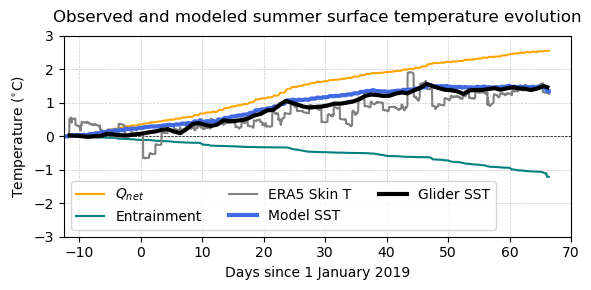

In [25]:
fig, ax = plt.subplots(figsize=(6,3))

ax.axhline(c='k', lw=0.5, ls='--')

# plot the individual terms
ax.plot(ds_era5_site.dayofyear, proj_sst_heat_flux, label='$Q_{net}$', lw=1.5, c='orange')
ax.plot(ds_era5_site.dayofyear, proj_sst_entrainment, label='Entrainment', lw=1.5, c='teal')

ax.plot(ds_era5_site.dayofyear, ds_era5_site.skt-273.15 - (ds_era5_site.skt-273.15)[0], label='ERA5 Skin T', lw=1.5, ls='-', c='0.5')
# ax.plot(ds_era5_site.DOY, ds_era5_site.sst-273.15 - (ds_era5_site.sst-273.15)[0], label='ERA5 sst', lw=2, c='tab:purple')

# plot the net modelled sst
ax.plot(ds_era5_site.dayofyear, ds_era5_site.proj_sst_net, label='Model SST', lw=3, c='royalblue')

# glider observations
ax.plot(sl_sst_1d.DOY, sl_sst_1d.sst-0.6, c='k', lw=3, label='Glider SST')

ax.set_xlim(-12.5, 70)
ax.set_ylim(-3, 3)

ax.legend(loc=3, ncol=3)

ax.set_xlabel('Days since 1 January 2019')
ax.set_ylabel('Temperature ($^{\circ}$C)')

ax.grid(ls='--', c='0.8', lw=0.5)

ax.set_title('Observed and modeled summer surface temperature evolution', fontsize=12, pad=10)

fig.tight_layout()

plt.savefig('/home/mduplessis/projects/duplessis-storms-warming/figs/ext-data-modeled-temp.png', dpi=600)

#### Figure 2 main plot

In [22]:
# calcualte daily mean of the ERA5 variables

ds_era5_site_1D = ds_era5_site.resample(time='1D').mean()
ds_era5_site_1D = ds_era5_site_1D.isel(time=np.arange(ds_era5_site_1D.time.size)[1:])

# and the sst

sl_sst_1d = sl_sst.resample(time='1D').mean()

In [23]:
# calculate the buoyancy fluxes

import gsw

g = -9.81
alpha = gsw.alpha(34, ds_era5_site.sst, p=0)
rho = 1027
cp = 4000

ds_era5_site['Bo'] = -(g*alpha*ds_era5_site.qnet)/(rho*cp)

ds_era5_site_1D = ds_era5_site.resample(time='1D').mean()

In [24]:
def perform_running_mean(sl_grid, window_size=20, min_periods=5):
    """
    Perform a running mean on the stratification arrays.

    Parameters:
    sl_grid (xarray.Dataset): Dataset containing 'N2', 'N2_S', and 'N2_T' variables.
    window_size (int): The size of the moving window.
    min_periods (int): Minimum number of observations in window required to have a value.

    Returns:
    xarray.Dataset: Updated dataset with running mean variables.
    """
    # Initialize arrays for running mean results
    N2_rm = np.empty(sl_grid.N2.shape)
    N2_S_rm = np.empty(sl_grid.N2.shape)
    N2_T_rm = np.empty(sl_grid.N2.shape)

    # Perform running mean for each time step
    for i in range(sl_grid.time.size):
        N2_series = pd.Series(sl_grid.N2.isel(time=i).values)
        N2_S_series = pd.Series(sl_grid.N2_S.isel(time=i).values)
        N2_T_series = pd.Series(sl_grid.N2_T.isel(time=i).values)

        N2_rm[:, i] = N2_series.rolling(window=window_size, min_periods=min_periods, center=True).mean()
        N2_S_rm[:, i] = N2_S_series.rolling(window=window_size, min_periods=min_periods, center=True).mean()
        N2_T_rm[:, i] = N2_T_series.rolling(window=window_size, min_periods=min_periods, center=True).mean()

    # Add running mean results to the dataset
    sl_grid['N2_rm'] = (('depth', 'time'), N2_rm)
    sl_grid['N2_S_rm'] = (('depth', 'time'), N2_S_rm)
    sl_grid['N2_T_rm'] = (('depth', 'time'), N2_T_rm)

    return sl_grid

sl_grid = perform_running_mean(sl_grid)

In [54]:
from matplotlib.colors import LogNorm

# a function to calculate and plot the rate of warming during the four warming periods

from scipy import stats

def plot_reg(x, y, doy_min, doy_max, ax, color, label=False):
    """
    Calculate and plot the rate of warming during a specified period.

    Parameters:
    x (array-like): Independent variable (e.g., day of year).
    y (array-like): Dependent variable (e.g., temperature).
    doy_min (int): Minimum day of year for the period.
    doy_max (int): Maximum day of year for the period.
    ax (matplotlib.axes.Axes): Matplotlib axis object to plot on.
    color (str): Color for the regression line.
    label (bool): Whether to add a label to the regression line.

    Returns:
    res (scipy.stats._stats_mstats_common.LinregressResult): Regression result.
    """
    # Select the subset of data within the specified period
    idx = (x > doy_min) & (x < doy_max)
    x_subset = x[idx]
    y_subset = y[idx]

    # Create a linear regression model
    res = stats.linregress(x_subset, y_subset)
    
    print(f"R-squared: {res.rvalue**2:.6f}")
    print(f'degC/day: {res.slope:.6f}')

    # Plot the regression line
    ax.plot(x_subset, res.intercept + res.slope * x_subset, c=color, label='Period regression' if label else None, lw=2, ls='--')

    return res

In [116]:
font = {'size': 9}
plt.rc('font', **font)

/tmp/ipykernel_905157/1009592406.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


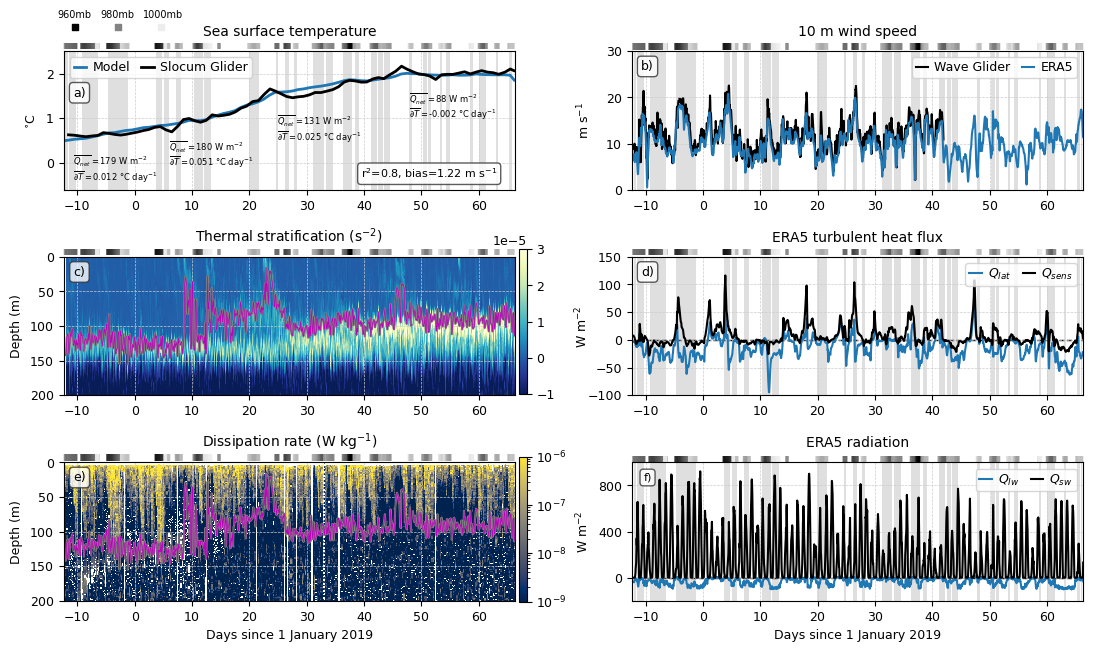

In [159]:
fig, ax = plt.subplots(3, 2, figsize=(11, 6.5))
fig.subplots_adjust(hspace=1, wspace=3)

# Plot near-surface temperature
ax[0,0].plot(ds_era5_site_1D.dayofyear, ds_era5_site_1D.proj_sst_net + 0.5, label='Model', c='tab:blue', lw=2)
ax[0,0].plot(sl_sst_1d.DOY, sl_sst_1d.sst, c='k', lw=2, label='Slocum Glider')

ax[0,0].legend(loc='upper left', fontsize=9, ncol=2, handlelength=1, handletextpad=0.5, borderpad=0.3, columnspacing=0.9, labelspacing=0.5)

ax[0,0].set_ylim(-0.6, 2.5)
ax[0,0].set_title('Sea surface temperature', fontsize=10, pad=11)
ax[0,0].set_ylabel('$^{\circ}$C', labelpad=5)

ax[0,0].text(-13.5, 3.25, '960mb', fontsize=7)
ax[0,0].text(-6, 3.25, '980mb', fontsize=7)
ax[0,0].text(1.5, 3.25, '1000mb', fontsize=7)

ax[0,0].scatter(-10.5, 3.05, c=940,  cmap='Greys_r', marker='s', s=20, clip_on=False, label='Storms', vmin=940, vmax=1010)
ax[0,0].scatter(-3, 3.05, c=970,  cmap='Greys_r', marker='s', s=20, clip_on=False, label='Storms', vmin=940, vmax=1010)
ax[0,0].scatter(4.5, 3.05, c=1000, cmap='Greys_r', marker='s', s=20, clip_on=False, label='Storms', vmin=940, vmax=1010)

# Identify consecutive storm periods
storm_periods = ds_era5_site['storm_present'].data
consecutive_storms = np.diff(np.concatenate(([0], storm_periods, [0])))
start_indices = np.where(consecutive_storms == 1)[0]
end_indices = np.where(consecutive_storms == -1)[0]

# Shading consecutive storm periods
for start, end in zip(start_indices, end_indices):
    ax[0,0].fill_between(ds_era5_site['dayofyear'][start:end], -200, 1000, color='gray', alpha=0.25, edgecolor='none')
    ax[0,1].fill_between(ds_era5_site['dayofyear'][start:end], 0, 30, color='gray', alpha=0.25, edgecolor='none')
    ax[1,1].fill_between(ds_era5_site['dayofyear'][start:end], -150, 150, color='gray', alpha=0.25, edgecolor='none')
    ax[2,1].fill_between(ds_era5_site['dayofyear'][start:end], -200, 1000, color='gray', alpha=0.25, edgecolor='none')


# Plot thermal stratification
img_st = ax[1,0].pcolormesh(sl_grid.DOY, sl_grid.depth, sl_grid.N2_T_rm.interpolate_na(dim='time'), vmin=-1e-5, vmax=3e-5, cmap='YlGnBu_r')

caxis = fig.add_axes([0.475, 0.4023, 0.007, 0.223])
cb = fig.colorbar(mappable=img_st, cax=caxis, orientation='vertical')
# cb.outline.set_edgecolor('white')
# cb.ax.xaxis.set_tick_params(color='white', labelcolor='white', labelsize=10)

ax[1,0].plot(sl_grid.DOY, sl_grid.mld_t, c='0.5', lw=1.5, ls='-', label='MLD')
ax[1,0].plot(sl_grid.DOY, sl_grid.mld_t, c='m', lw=0.5, ls='-', label='MLD')

ax[1,0].set_ylim(200,0)
ax[1,0].set_title('Thermal stratification (s$^{-2}$)', fontsize=10, pad=11)
ax[1,0].set_ylabel('Depth (m)', labelpad=5)

# Plot dissipation rate
img_ep = ax[2,0].pcolormesh(sl_eps.DOY, sl_eps.DEPTH, sl_eps.EPS_FINAL, norm=LogNorm(vmin=10e-10, vmax=10e-7), cmap='cividis', shading='auto')

caxis = fig.add_axes([0.475, 0.083, 0.007, 0.223])
cb = fig.colorbar(mappable=img_ep, cax=caxis, orientation='vertical')
cb.outline.set_edgecolor('k')
cb.ax.xaxis.set_tick_params(color='k', labelcolor='k', labelsize=12, length=5)

# ax[2,0].plot(sl_xld.DOY, sl_xld.xld, c='gold', lw=1) 
ax[2,0].plot(sl_grid.DOY, sl_grid.mld_t, c='0.5', lw=1.5, ls='-', label='MLD')
ax[2,0].plot(sl_grid.DOY, sl_grid.mld_t, c='m', lw=0.5, ls='-', label='MLD')

ax[2,0].set_ylim(200,0)
ax[2,0].set_title('Dissipation rate (W kg$^{-1}$)', fontsize=10, pad=11)
ax[2,0].set_ylabel('Depth (m)', labelpad=5)

for a in ax.flatten():
    a.set_xlim(-12.4, 66.3)
    a.grid(ls='--', c='0.8', lw=0.5) 
    
    storm_id = np.unique(storms_soscex.storm_id)

    for storm in storm_id:
        single_storm = storms_soscex.isel(time=storms_soscex.storm_id==storm)
        ax[0,0].scatter(single_storm['dayofyear'], np.zeros(single_storm.time.size)+2.62, c=single_storm['pressure'], cmap='Greys_r', marker='|', s=20, clip_on=False, vmin=940, vmax=1010)    
        ax[1,0].scatter(single_storm['dayofyear'], np.zeros(single_storm.time.size)-7,    c=single_storm['pressure'], cmap='Greys_r', marker='|', s=20, clip_on=False, vmin=940, vmax=1010)
        ax[2,0].scatter(single_storm['dayofyear'], np.zeros(single_storm.time.size)-7,    c=single_storm['pressure'], cmap='Greys_r', marker='|', s=20, clip_on=False, vmin=940, vmax=1010)    

        ax[0,1].scatter(single_storm['dayofyear'], np.zeros(single_storm.time.size)+31,    c=single_storm['pressure'], cmap='Greys_r', marker='|', s=20, clip_on=False, vmin=940, vmax=1010)    
        ax[1,1].scatter(single_storm['dayofyear'], np.zeros(single_storm.time.size)+158,    c=single_storm['pressure'], cmap='Greys_r', marker='|', s=20, clip_on=False, vmin=940, vmax=1010)    
        ax[2,1].scatter(single_storm['dayofyear'], np.zeros(single_storm.time.size)+1030,    c=single_storm['pressure'], cmap='Greys_r', marker='|', s=20, clip_on=False, vmin=940, vmax=1010)    

ax[2,0].set_xlabel('Days since 1 January 2019')
ax[2,1].set_xlabel('Days since 1 January 2019')

# Define x and y coordinates for plotting
x_coords = [-11.7, 5, 23.8, 46.8, 66.5]
y_coords = [0.2, 0.525, 1.1, 1.6]

# ax[0,0].plot([x_coords[0], x_coords[0]], [-0.5, 0.60], c='k', lw=1, ls='--')
# ax[0,0].plot([x_coords[1], x_coords[1]], [-0.1, 0.75], c='k', lw=1, ls='--')
# ax[0,0].plot([x_coords[2], x_coords[2]], [0.50, 1.49], c='k', lw=1, ls='--')
# ax[0,0].plot([x_coords[3], x_coords[3]], [1.00, 2.00], c='k', lw=1, ls='--')
# ax[0,0].plot([x_coords[4], x_coords[4]], [y_coords[3], 2.05], c='k', lw=1, ls='--')

for i in range(len(x_coords) - 1):

    # plot_reg(sl_sst.DOY.values, sl_sst.sst.values, x_coords[i], x_coords[i + 1], ax[0,0], color='tab:red', label=(i == len(x_coords) - 2))
    
    q_mean = np.round(ds_era5_site.isel(time=((ds_era5_site.dayofyear > x_coords[i]) & (ds_era5_site.dayofyear < x_coords[i + 1]))).qnet.mean(dim='time').data)
    ax[0,0].text(x_coords[i] + 1, y_coords[i] - 0.25, r'$\overline{Q_{net}} = $' + str(q_mean.astype(int)) + ' W m$^{-2}$', fontsize=6)
    
    dt_mean = np.round(sl_sst_1d.isel(time=((sl_sst_1d.DOY > x_coords[i]) & (sl_sst_1d.DOY < x_coords[i + 1]))).sst.diff(dim='time').mean(dim='time').data, decimals=3)
    ax[0,0].text(x_coords[i] + 1, y_coords[i] - 0.6, r'$\overline{\partial T} = $' + str(dt_mean) + ' °C day$^{-1}$', fontsize=6)

# Plot wind speed
ax[0,1].plot(wg['dayofyear'], wg['WindSpeed_ms_10m'], c='k', label='Wave Glider')
ax[0,1].plot(ds_era5_site.dayofyear, ds_era5_site.wnd, label='ERA5')

ax[0,1].set_ylim(0, 30)
ax[0,1].set_ylabel('m s$^{-1}$', labelpad=10)
ax[0,1].legend(loc=1, handlelength=1, handletextpad=0.5, borderpad=0.3, fontsize=9, ncol=2, frameon=True, columnspacing=0.9, labelspacing=0.5)
ax[0,1].set_title('10 m wind speed', fontsize=10, pad=11)

# Plot turbulent heat flux
ax[1,1].plot(ds_era5_site.dayofyear, ds_era5_site.slhf, label='$Q_{lat}$')
ax[1,1].plot(ds_era5_site.dayofyear, ds_era5_site.sshf, label='$Q_{sens}$', c='k')

ax[1,1].axhline(0, c='k', lw=1, ls='--', zorder=0)
ax[1,1].set_ylim(-100, 150)
ax[1,1].set_ylabel('W m$^{-2}$', labelpad=-2)
ax[1,1].legend(loc=1, handlelength=1, handletextpad=0.5, borderpad=0.3, fontsize=9, ncol=2, frameon=True, columnspacing=0.9, labelspacing=0.5)
ax[1,1].set_title('ERA5 turbulent heat flux', fontsize=10, pad=11)

# Plot radiative flux
ax[2,1].plot(ds_era5_site.dayofyear, ds_era5_site.str, label='$Q_{lw}$')
ax[2,1].plot(ds_era5_site.dayofyear, ds_era5_site.ssr, label='$Q_{sw}$', c='k')

ax[2,1].axhline(0, c='k', lw=1, ls='--', zorder=0)
ax[2,1].set_ylim(-200, 1000)
ax[2,1].set_ylabel('W m$^{-2}$', labelpad=5)
ax[2,1].legend(loc=1, handlelength=1, handletextpad=0.5, borderpad=0.3, fontsize=9, ncol=2, frameon=True, columnspacing=0.9, labelspacing=0.5)
ax[2,1].set_title('ERA5 radiation', fontsize=10, pad=11)
ax[2,1].yaxis.set_ticks(np.arange(0, 1200, 400)) 

fig.tight_layout()

ax[0,0].text(0.035, 0.7, 'a)', fontsize=9, ha='center', va='center', transform=ax[0,0].transAxes, bbox=dict(facecolor='white', edgecolor='0.2', alpha=0.8, pad=0.5, boxstyle='round,pad=0.3'))
ax[0,1].text(0.035, 0.89, 'b)', fontsize=9, ha='center', va='center', transform=ax[0,1].transAxes, bbox=dict(facecolor='white', edgecolor='0.2', alpha=0.8, pad=0.5, boxstyle='round,pad=0.3'))
ax[1,0].text(0.035, 0.89, 'c)', fontsize=9, ha='center', va='center', transform=ax[1,0].transAxes, bbox=dict(facecolor='white', edgecolor='0.2', alpha=0.8, pad=0.5, boxstyle='round,pad=0.3'))    
ax[1,1].text(0.035, 0.89, 'd)', fontsize=9, ha='center', va='center', transform=ax[1,1].transAxes, bbox=dict(facecolor='white', edgecolor='0.2', alpha=0.8, pad=0.5, boxstyle='round,pad=0.3'))
ax[2,0].text(0.035, 0.89, 'e)', fontsize=9, ha='center', va='center', transform=ax[2,0].transAxes, bbox=dict(facecolor='white', edgecolor='0.2', alpha=0.8, pad=0.5, boxstyle='round,pad=0.3'))
ax[2,1].text(0.035, 0.89, 'f)', fontsize=8, ha='center', va='center', transform=ax[2,1].transAxes, bbox=dict(facecolor='white', edgecolor='0.2', alpha=0.8, pad=0.5, boxstyle='round,pad=0.3'))

ax[0,0].text(0.810, 0.115, 'r$^2$=0.8, bias=1.22 m s$^{-1}$', fontsize=8, ha='center', va='center', transform=ax[0,0].transAxes, bbox=dict(facecolor='white', edgecolor='0.2', alpha=0.8, pad=0.5, boxstyle='round,pad=0.3'))

plt.savefig('/home/mduplessis/projects/duplessis-storms-warming/figs/figure2.png', dpi=600)

In [163]:
storms_soscex

<xarray.Dataset> Size: 58MB
Dimensions:    (time: 867, x: 41, y: 41)
Coordinates:
  * x          (x) int64 328B -1000 -950 -900 -850 -800 ... 800 850 900 950 1000
  * y          (y) int64 328B -1000 -950 -900 -850 -800 ... 800 850 900 950 1000
  * time       (time) datetime64[ns] 7kB 2018-12-19T22:00:00 ... 2019-03-08T0...
    lon        (time) float64 7kB ...
    lat        (time) float64 7kB ...
Data variables:
    ssr        (time, x, y) float64 12MB ...
    pressure   (time) float64 7kB ...
    storm_id   (time) int64 7kB 73537 73537 73537 73537 ... 73886 73886 73886
    str        (time, x, y) float64 12MB ...
    sshf       (time, x, y) float64 12MB ...
    slhf       (time, x, y) float64 12MB ...
    wnd        (time, x, y) float64 12MB ...
    dayofyear  (time) float64 7kB -12.08 -12.04 -12.0 ... 65.96 66.0 66.04

In [164]:
for s in np.unique(storms_soscex.storm_id):

    single_storm = storms_soscex.isel(time=storms_soscex.storm_id==s)

    print(f"Storm ID: {s}")
    print(f"Start Date: {single_storm.time.min().values}")
    print(f"End Date: {single_storm.time.max().values}")
    print(f"Max Wind Speed: {single_storm.wnd.max().values} m/s")
    print(f"Min Pressure: {single_storm.pressure.min().values} hPa")
    print(f"Mean SSHF: {single_storm.sshf.mean().values} W m$^{-2}$")
    print(f"Mean SLHF: {single_storm.slhf.mean().values} W m$^{-2}$")
    print(f"Mean SSR: {single_storm.ssr.mean().values} W m$^{-2}$")
    print(f"Mean STR: {single_storm.str.mean().values} W m$^{-2}$")
    print("-" * 40)

Storm ID: 73537
Start Date: 2018-12-19T22:00:00.000000000
End Date: 2018-12-20T10:00:00.000000000
Max Wind Speed: 25.265652277262962 m/s
Min Pressure: 964.948778621076 hPa
Mean SSHF: 12.754414072440607 W m$^-2$
Mean SLHF: -19.08330454283621 W m$^-2$
Mean SSR: 104.9995527648134 W m$^-2$
Mean STR: -34.965889745149056 W m$^-2$
----------------------------------------
Storm ID: 73544
Start Date: 2018-12-20T13:00:00.000000000
End Date: 2018-12-21T17:00:00.000000000
Max Wind Speed: 23.44416609958035 m/s
Min Pressure: 961.97833307265 hPa
Mean SSHF: 9.328987345054966 W m$^-2$
Mean SLHF: -27.11274195487275 W m$^-2$
Mean SSR: 285.2348973992945 W m$^-2$
Mean STR: -41.4464655322957 W m$^-2$
----------------------------------------
Storm ID: 73553
Start Date: 2018-12-23T14:00:00.000000000
End Date: 2018-12-23T18:00:00.000000000
Max Wind Speed: 16.71457562289729 m/s
Min Pressure: 987.910343014207 hPa
Mean SSHF: 1.6871882607167383 W m$^-2$
Mean SLHF: -45.596502839001054 W m$^-2$
Mean SSR: 491.9022705

In [165]:
pressure_min_soscex_storms = np.zeros(np.unique(storms_soscex.storm_id).size)

for i, s in enumerate(np.unique(storms_soscex.storm_id)):

    single_storm = storms_soscex.isel(time=storms_soscex.storm_id==s)
 
    pressure_min_soscex_storms[i] = single_storm.pressure.min().values

In [ ]:
storms_soscex

(array([1., 1., 0., 1., 2., 2., 1., 3., 2., 4., 2., 4., 2., 4., 3., 3., 2.,
        0., 0., 4.]),
 array([940.15845428, 943.08483441, 946.01121454, 948.93759467,
        951.8639748 , 954.79035494, 957.71673507, 960.6431152 ,
        963.56949533, 966.49587546, 969.42225559, 972.34863572,
        975.27501585, 978.20139598, 981.12777611, 984.05415625,
        986.98053638, 989.90691651, 992.83329664, 995.75967677,
        998.6860569 ]),
 <BarContainer object of 20 artists>)

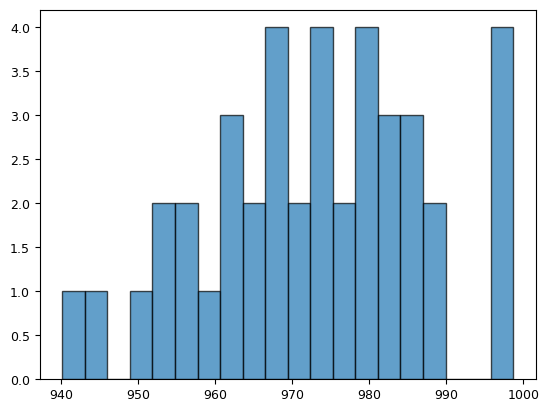

In [171]:
plt.hist(pressure_min_soscex_storms, bins=20, edgecolor='k', color='tab:blue', alpha=0.7)